# Red neuronal mixta con datos numéricos e imágenes
Para esta parte, partimos de los dataset que ya teníamos preparados en train y test y que contienen los datos numéricos. También usamos los que contienen la ruta de las imágenes y que están ordenados de la misma forma.

Recordemos que estos datasets los dejamos listos en el notebook de trataimiento de datos. [Tratamiento de datos](limpieza_datos.ipynb).

Las imágenes a las que hacemos referencia corresponden a las portadas de cada película y que no incluimos en el repositorio por el tamaño que ocupan.


In [28]:
import os
import pandas as pd

# Carga el dataset y devuelve un dataframe de Pandas
def load_airbnb_dataset(ruta,nombre,separador=';'):
    csv_path = os.path.join(ruta, nombre)
    return pd.read_csv(csv_path, sep=separador)

## Carga de datasets

In [15]:
train = load_airbnb_dataset('datasets','train_final.csv')
test = load_airbnb_dataset('datasets','test_final.csv')
dfTrainImagenes = load_airbnb_dataset('datasets','imagenes_train_final.csv')
dfTestImagenes = load_airbnb_dataset('datasets','imagenes_test_final.csv')

## Carga de imágenes

In [16]:
import cv2
import os
import numpy as np

def cargaImagenes(dataF):
    inputImages = []

    origHeight = 336
    origWidth = 224
    origChann = 3

    for ruta in dataF['local_poster_path']:
        ruta = ruta[3:]  # Quito caracteres sobrantes

        image = cv2.imread(ruta)

        height, width, channels = image.shape

        if (height != origHeight) or (width != origWidth) or (channels != origChann):
            raise ValueError('Tamaño incorrecto en imagen:', ruta)
        
        inputImages.append(image)

    return np.array(inputImages)

In [17]:
imagenesTrain = cargaImagenes(dfTrainImagenes)
imagenesTest = cargaImagenes(dfTestImagenes)

## Escalado de datos
### Escalar imágenes en rango de 0,1

In [18]:
imagenesTrain = imagenesTrain / 255.0
imagenesTest = imagenesTest / 255.0

### Escalar datos numéricos

In [19]:
from sklearn import preprocessing

# Separo la Y del resto de datos
dataPrecio = train['vote_average']
dataSinPrecio = train.drop(['vote_average'], axis=1, inplace=False)

dataPrecioTest = test['vote_average']
dataSinPrecioTest = test.drop(['vote_average'], axis=1, inplace=False)

y_train = dataPrecio.values
X_train = dataSinPrecio.values

y_test = dataPrecioTest.values
X_test = dataSinPrecioTest.values

feature_names = train.columns[:]

# Obtener precio máximo en Train, y escalamos los precios de test y train en rango de [0, 1]
maxPrice = train["vote_average"].max()
trainY = train["vote_average"] / maxPrice
testY = test["vote_average"] / maxPrice

# Escalamos variables numéricas de train y test
scaler = preprocessing.StandardScaler().fit(X_test)
XtestScaled = scaler.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

### Red neuronal (MLP)

In [20]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

def create_mlp(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(27, input_dim=dim, activation="relu"))
	model.add(Dense(9, activation="relu"))
	model.add(Dense(3, activation="relu"))
	model.add(Dense(1, activation="linear"))
	
	return model

### Red neuronal convolucional (CNN)

In [21]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(10)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

### Creación de modelos, concatenación MLP con CNN y generación de modelo final
Obtenemos ahora el modelo MLP y el CNN, luego los concatenamos y generamos un nuevo modelo con la unión

In [22]:
from keras.layers import concatenate

# create the MLP and CNN models
mlp = create_mlp(XtrainScaled.shape[1])
cnn = create_cnn(224, 336, 3, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

### Compilar y entrenar modelo

In [10]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)
# train the model
print("[INFO] training model...")
historico = model.fit(
	[XtrainScaled, imagenesTrain], trainY,
	validation_data=([XtestScaled, imagenesTest], testY),
	epochs=200, batch_size=8)


[INFO] training model...


Train on 7921 samples, validate on 1977 samples
Epoch 1/200
7921/7921 [==============================] - 100s 13ms/step - loss: 0.1467 - val_loss: 0.0259
Epoch 2/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0190 - val_loss: 0.0231
Epoch 3/200
7921/7921 [==============================] - 62s 8ms/step - loss: 0.0184 - val_loss: 0.0222
Epoch 4/200
7921/7921 [==============================] - 63s 8ms/step - loss: 0.0184 - val_loss: 0.0214
Epoch 5/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0184 - val_loss: 0.0215
Epoch 6/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0184 - val_loss: 0.0214
Epoch 7/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0184 - val_loss: 0.0214
Epoch 8/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0184 - val_loss: 0.0214
Epoch 9/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0184 - val

7921/7921 [==============================] - 61s 8ms/step - loss: 0.0091 - val_loss: 0.0175
Epoch 73/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0089 - val_loss: 0.0166
Epoch 74/200
7921/7921 [==============================] - 61s 8ms/step - loss: 0.0090 - val_loss: 0.0187
Epoch 75/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0090 - val_loss: 0.0178
Epoch 76/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0090 - val_loss: 0.0177
Epoch 77/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0089 - val_loss: 0.0177
Epoch 78/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0086 - val_loss: 0.0181
Epoch 79/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0089 - val_loss: 0.0189
Epoch 80/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0089 - val_loss: 0.0179
Epoch 81/200
7921/7921 [==============================] - 61s 8ms/st

7921/7921 [==============================] - 60s 8ms/step - loss: 0.0044 - val_loss: 0.0209
Epoch 150/200
7921/7921 [==============================] - 73s 9ms/step - loss: 0.0040 - val_loss: 0.0207
Epoch 151/200
7921/7921 [==============================] - 77s 10ms/step - loss: 0.0041 - val_loss: 0.0203
Epoch 152/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0040 - val_loss: 0.0208
Epoch 153/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0040 - val_loss: 0.0205
Epoch 154/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0039 - val_loss: 0.0198
Epoch 155/200
7921/7921 [==============================] - 80s 10ms/step - loss: 0.0042 - val_loss: 0.0210
Epoch 156/200
7921/7921 [==============================] - 77s 10ms/step - loss: 0.0037 - val_loss: 0.0197
Epoch 157/200
7921/7921 [==============================] - 60s 8ms/step - loss: 0.0038 - val_loss: 0.0202
Epoch 158/200
7921/7921 [==============================] 

### Curva de pérdidas de los datos de train y test

Text(0, 0.5, 'Loss')

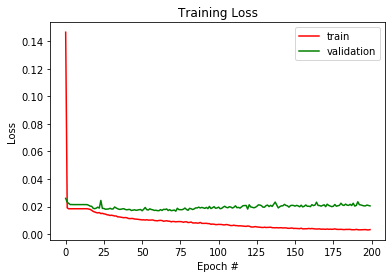

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0, 200), historico.history["loss"], 'r')
plt.plot(np.arange(0, 200), historico.history["val_loss"], 'g')
plt.title("Training Loss")
plt.legend(['train','validation'])
plt.xlabel("Epoch #")
plt.ylabel("Loss")

Como se puede ver, a partir de la época 20 el modelo empieza a entrar en overfitting, por tanto, reiniciamos la red y entrenamos solo hasta la época 20 para analizar los resultados.

In [23]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)
# train the model
print("[INFO] training model...")
historico = model.fit(
	[XtrainScaled, imagenesTrain], trainY,
	validation_data=([XtestScaled, imagenesTest], testY),
	epochs=20, batch_size=8)

[INFO] training model...
Train on 7921 samples, validate on 1977 samples
Epoch 1/20
7921/7921 [==============================] - 67s 8ms/step - loss: 0.0942 - val_loss: 0.0231
Epoch 2/20
7921/7921 [==============================] - 64s 8ms/step - loss: 0.0238 - val_loss: 0.0215
Epoch 3/20
7921/7921 [==============================] - 64s 8ms/step - loss: 0.0196 - val_loss: 0.0213
Epoch 4/20
7921/7921 [==============================] - 65s 8ms/step - loss: 0.0185 - val_loss: 0.0206
Epoch 5/20
7921/7921 [==============================] - 64s 8ms/step - loss: 0.0174 - val_loss: 0.0192
Epoch 6/20
7921/7921 [==============================] - 66s 8ms/step - loss: 0.0159 - val_loss: 0.0183
Epoch 7/20
7921/7921 [==============================] - 65s 8ms/step - loss: 0.0154 - val_loss: 0.0175
Epoch 8/20
7921/7921 [==============================] - 65s 8ms/step - loss: 0.0148 - val_loss: 0.0175
Epoch 9/20
7921/7921 [==============================] - 65s 8ms/step - loss: 0.0144 - val_loss: 0.0175


### Curva de pérdidas de los datos de train y test

Text(0, 0.5, 'Loss')

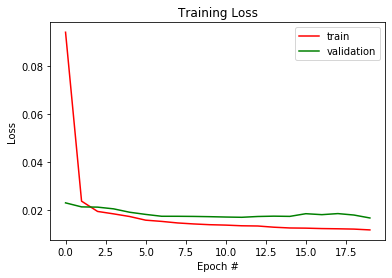

In [24]:
plt.plot(np.arange(0, 20), historico.history["loss"], 'r')
plt.plot(np.arange(0, 20), historico.history["val_loss"], 'g')
plt.title("Training Loss")
plt.legend(['train','validation'])
plt.xlabel("Epoch #")
plt.ylabel("Loss")

### Evaluación del modelo
Una vez entrenado el modelo, lo evaluamos y vemos los resultados.

In [29]:
print("[INFO] prediciendo valoraciones de películas...")
preds = model.predict([XtestScaled, imagenesTest])

# Cargar dataset original
df = load_airbnb_dataset('datasets', 'db_practica_kc_public_dataset_final.csv', ',')

# Comprobar la diferencia entre las valoraciones que ha predecido con los que tenemos en el dataset
diff = preds.flatten() - testY

percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# Hay alguna valoración de test 0, al dividir da inf, lo reemplazamos por 0
absPercentDiff = absPercentDiff.replace([np.inf, -np.inf], 0)

# Calculamos la media y la desviación estándar
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# Vemos las estadísticas
print('[INFO] media valoración película: ', df["vote_average"].mean(), 
      ', desviación valoración película: ', df["vote_average"].std())

print("[INFO] media del error: {:.2f}%, desviación del error: {:.2f}%".format(mean, std))

[INFO] prediciendo valoraciones de películas...
[INFO] media valoración película:  6.2358199999999995 , desviación valoración película:  1.4887862761516863
[INFO] media del error: 11.48%, desviación del error: 13.19%


# Resultados
Nuestra red neuronal nos da una pérdida de 0.0119 en train y de 0.0168 en test.

El cálculo del error absoluto es de 11,48%, esto significa que de promedio, nuestra red se alejará un 11,48% en las predicciones de valoraciones de películas, con una desviación del 13,19%.